#   Importation des librairies

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import time
import glob
import os
import shutil

import pydot
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score, roc_auc_score, f1_score

pd.set_option('display.width', 150)

from keras.utils import to_categorical, plot_model
from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

# Préparation des données

On va définir les répertoires des fichiers. On a opté pour kaggle compte tenu d'un certain nombre d'avantage qu'il présente. En effet, contrairement à moi googleCollab, on a plus besoin de charger tous les images sur notre drive avant de les importer (Un importation sur drive estimé à 7h de durée). Par ailleurs, les modèles sont extrêments long à tourner sur nos machines.

In [2]:
covid_dir='../input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID'
lung_opacity_dir='../input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Lung_Opacity'
normal_dir='../input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal'
pneumonia_dir='../input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Viral Pneumonia'

In [3]:
dirlist=[covid_dir, lung_opacity_dir, normal_dir, pneumonia_dir]
classes=['covid', 'lung_opacity', 'normal', 'pneumonia']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  21165    labels:  21165


In [4]:
Fseries=pd.Series(filepaths, name='file_paths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)
df=DataFrame(np.array(df).reshape(21165,2), columns = ['file_paths', 'labels'])
print(df['labels'].value_counts())

normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: labels, dtype: int64


On peut remarquer un énorme déséquilibre entre les differents facteurs. L'idée étant de nous focaliser sur la détection du covid, on va réduire la taille des modalités **nomal** et **lung_opacity** à la taille de covid.

In [6]:
#Compte du nombre d'élément à retirer
normal_count = 10192
lung_opacity_count = 6012
covid_count = 3616
normal_image_max_index = (df.labels.values == 'normal').argmax()
print(normal_image_max_index)
lung_opacity_max_index = (df.labels.values == 'lung_opacity').argmax()
print(lung_opacity_max_index)

9628
3616


In [7]:
for i in range(normal_count - covid_count):
    df = df.drop([normal_image_max_index + i])
    
for n in range(lung_opacity_count - covid_count):
    df = df.drop([lung_opacity_max_index + n])

df['labels'].value_counts()

covid           3616
lung_opacity    3616
normal          3616
pneumonia       1345
Name: labels, dtype: int64

Le dernier élément à équilibrer est la **pneumonia**, pour équilibré les données, on a décider d'importer d'autres radiographie de pneumonia, également présente sur kaggle. On a préféré cette solution qui présente à notre avis, plus d'avantage qu'une data augmentation. L'idée étant éventuellement de faire une data augmentation pour voir si cela améliore les résultats de notre modèle

In [8]:
filepaths=[]
labels=[]
for file in glob.glob('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/*jpeg'):
    filepaths.append(file)
    labels.append('pneumonia')
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  3875    labels:  3875


In [9]:
fseries = pd.Series(filepaths, name='file_name', dtype='str')
lseries = pd.Series(labels, name='label', dtype='str')
extra_df = pd.concat([fseries, lseries], axis=1)
extra_df = DataFrame(np.array(extra_df).reshape(3875,2), columns = ['file_paths', 'labels'])
extra_df.head()

,file_paths,labels
0,../input/chest-xray-pneumonia/chest_xray/train...,pneumonia
1,../input/chest-xray-pneumonia/chest_xray/train...,pneumonia
2,../input/chest-xray-pneumonia/chest_xray/train...,pneumonia
3,../input/chest-xray-pneumonia/chest_xray/train...,pneumonia
4,../input/chest-xray-pneumonia/chest_xray/train...,pneumonia


In [10]:
df=pd.concat([df,extra_df], axis=0)
df=df.reset_index()

On va donc réduire les **pneumonie** pour avoir la même taille

In [11]:
# Compte des éléments
pneumonia_count=5220
pneumonia_max_index=(df.labels.values == 'pneumonia').argmax()
print(pneumonia_max_index)
for i in range(pneumonia_count - covid_count):
    df = df.drop([pneumonia_max_index + i])

10848


In [12]:
print(df['labels'].value_counts())
df.head()

covid           3616
lung_opacity    3616
normal          3616
pneumonia       3616
Name: labels, dtype: int64


,index,file_paths,labels
0,0,../input/covid19-radiography-dataset/COVID-19_...,covid
1,1,../input/covid19-radiography-dataset/COVID-19_...,covid
2,2,../input/covid19-radiography-dataset/COVID-19_...,covid
3,3,../input/covid19-radiography-dataset/COVID-19_...,covid
4,4,../input/covid19-radiography-dataset/COVID-19_...,covid


On peut ainsi observé que notre base de données est bien équilibré

# Constitution des échantillons...

In [13]:
target_size = (299,299)
batch_size = 64

In [14]:
train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input, validation_split=0.1)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [15]:
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
train_set = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical', subset='training')
valid_set = train_datagen.flow_from_dataframe(train_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical', subset='validation')
test_set = test_datagen.flow_from_dataframe(test_df, x_col='file_paths', y_col='labels', target_size=target_size, batch_size=batch_size, color_mode='rgb', shuffle=True, class_mode='categorical')

Found 10414 validated image filenames belonging to 4 classes.
Found 1157 validated image filenames belonging to 4 classes.
Found 2893 validated image filenames belonging to 4 classes.


In [16]:
classes=list(train_set.class_indices.keys())
print(classes)

['covid', 'lung_opacity', 'normal', 'pneumonia']


# Définition des fonctions 

In [18]:
def show_image_samples(gen):
    test_dict=test_set.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1)/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=10)
        plt.axis('off')
    plt.show()

#   Visualation des données

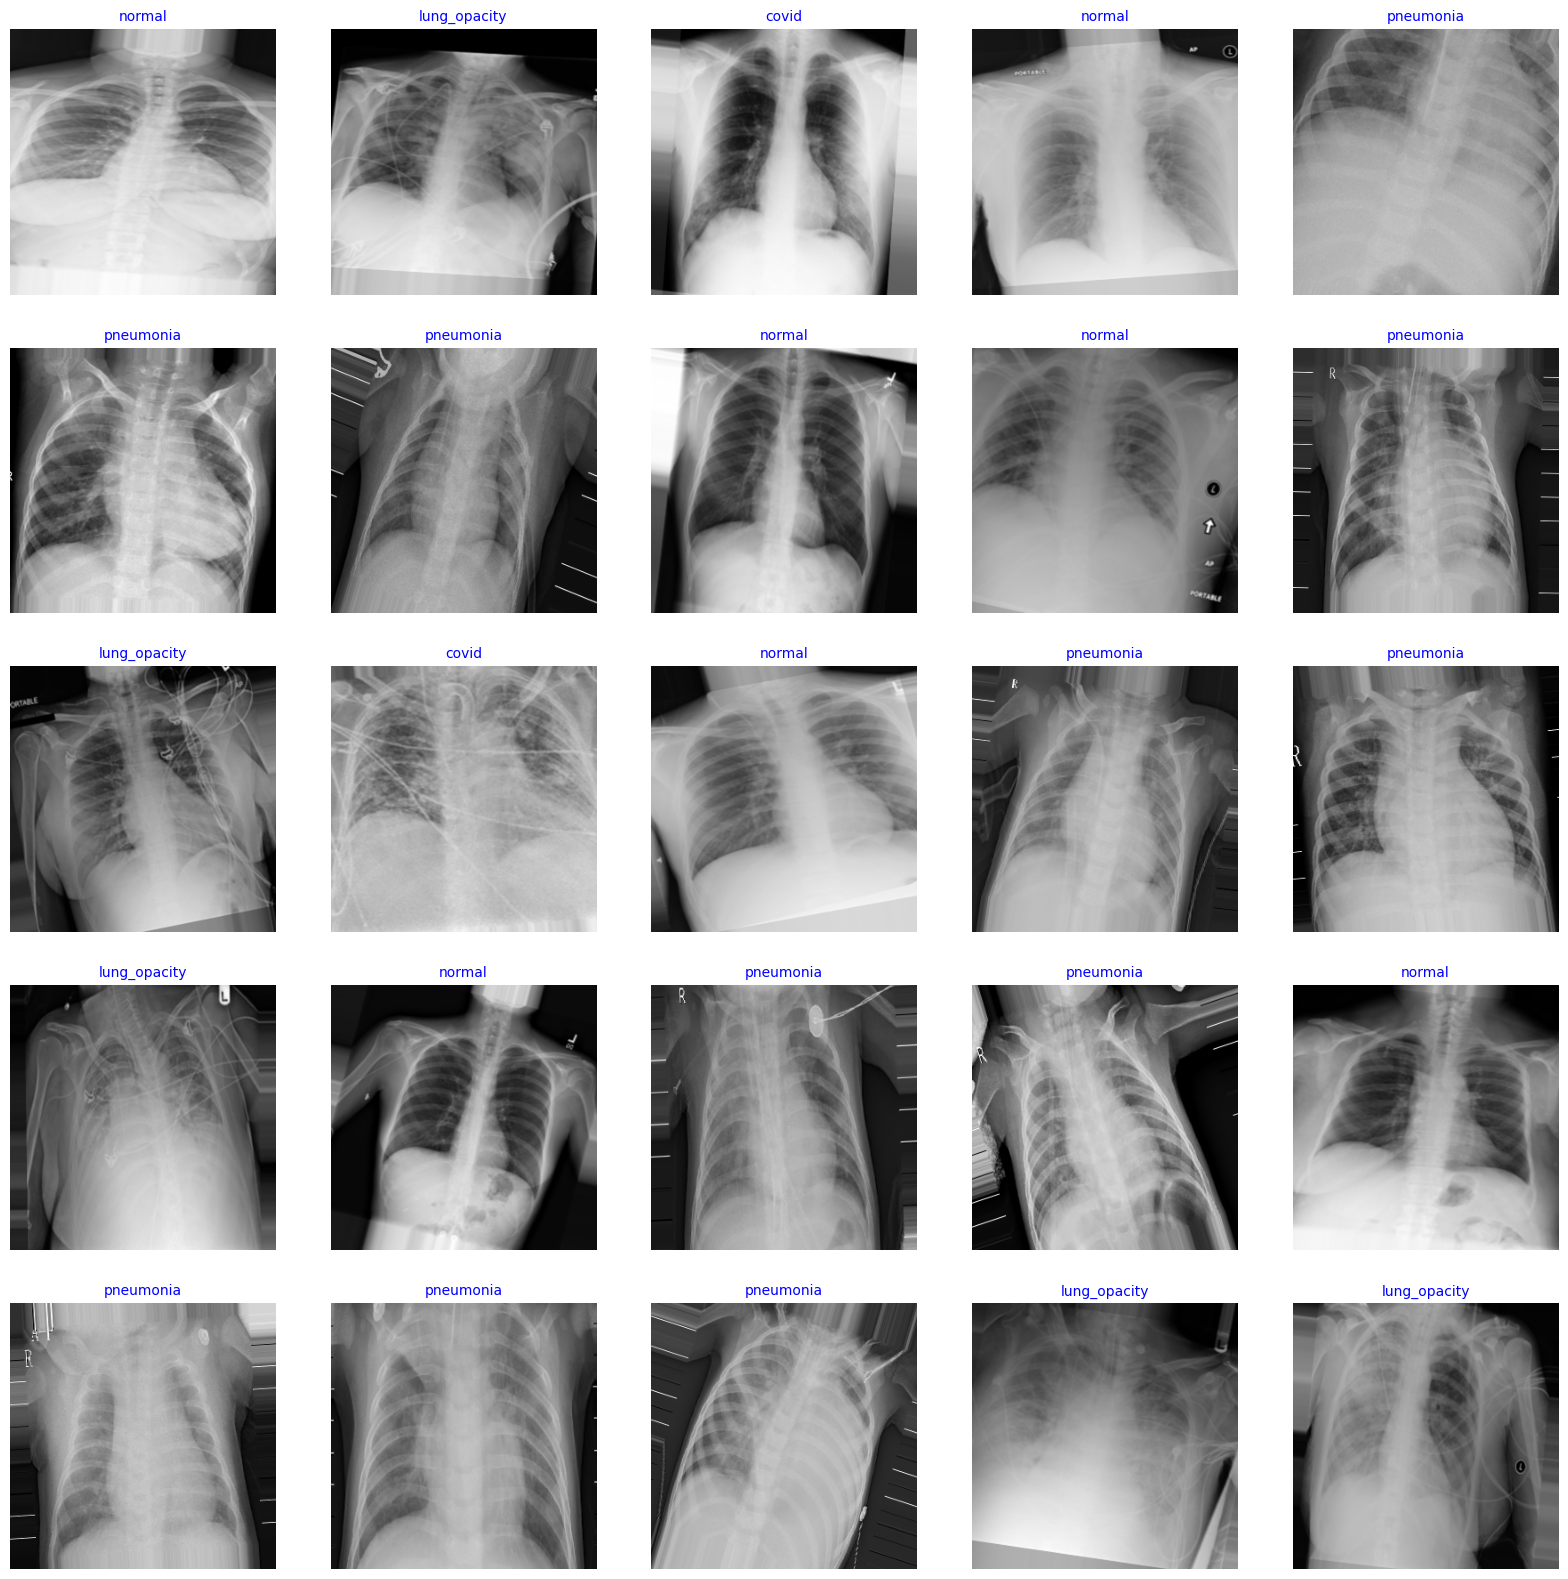

In [19]:
show_image_samples(train_set)

#   Analyse

In [20]:
input_shape=(299,299,3)
num_classes = len(classes)

In [21]:
def plot_loss(history):
    """
    Cette fonction trace la progression du training loss et de la validation loss
    ainsi que le meilleur epoch sur le même graphique.
    
    :param history: Objet history renvoyé par la méthode compile() (keras.callbacks.History)
    """
    # Plot du training loss et du validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    
    # Plot de l'epoch avec le meilleur validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    plt.scatter(best_epoch, history.history['val_loss'][best_epoch-1], marker='o', color='blue', label='Best epoch')
    
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history):
    """
    Cette fonction trace la progression de l'accuracy d'entraînement et de validation ainsi que le meilleur epoch sur le même graphique.
    
    :param history: Objet history renvoyé par la méthode compile() (keras.callbacks.History)
    """
    # Plot de l'accuracy d'entraînement et de validation
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    
    # Plot de l'epoch avec le meilleur validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    plt.scatter(best_epoch, history.history['val_accuracy'][best_epoch-1], marker='o', color='blue', label='Best epoch')
    
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [22]:
def affichage_matrix_confusion(y_true, y_predict, classes):
    plt.figure(figsize=(8,4))
    x = confusion_matrix(np.argmax(y_true, axis=1),np.argmax(y_predict, axis=1))
    Confusion_Matrix = pd.DataFrame(x, index=classes, columns=classes)
    sns.set(font_scale=1.5, color_codes=True, palette='deep')
    sns.heatmap(Confusion_Matrix, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(4)+.5, classes, rotation= 90)
    plt.yticks(np.arange(4)+.5, classes, rotation=0)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title('Confusion Matrix')
    plt.show()

In [24]:
def afficher_erreur_class(y_true, y_predit, classes):
    x = confusion_matrix(np.argmax(y_true, axis=1),np.argmax(y_predit, axis=1))
    conf_matrix = pd.DataFrame(x, index=classes, columns=classes)
    # Compute the number of true positives
    true_positives = np.diag(conf_matrix)
    # Compute the number of false positives and negatives
    false_positives = np.sum(conf_matrix, axis=0) - true_positives
    false_negatives = np.sum(conf_matrix, axis=1) - true_positives
    # Compute the total number of examples
    total_examples = np.sum(conf_matrix)
    # Compute the error rate by class
    error_rate = (false_positives + false_negatives) / total_examples
    # Create a bar plot of the error rate by class
    plt.figure(figsize=(12, 8))
    sns.barplot(x=classes, y=error_rate)
    plt.title('Error Rate by Class')
    plt.xlabel('Class')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [25]:
# Extraire y_true à partir du générateur de données de test
y_true = []
num_batches = len(test_set)
for i in range(num_batches):
    _, batch_y = next(test_set)
    y_true.extend(batch_y)
    
# Convertir y_true en un tableau numpy de forme (num_samples, num_classes)
y_true = np.array(y_true)

In [26]:
y_true

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

## Modèle pré-entrainés : Modèle InceptionResNetV2

In [57]:
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(299,299,3))

In [ ]:
base_model.summary()

In [59]:
model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    tf.keras.layers.Dense(256, activation='relu'), 
    tf.keras.layers.BatchNormalization(), tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(4, activation='softmax')
])
lr=0.001
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

In [61]:
patience = 1
stop_patience = 5
factor = 0.5

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=stop_patience, monitor='val_loss', verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, verbose=1)
]

In [62]:
epochs = 20
history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/20
163/163 [==============================] - 494s 2s/step - loss: 0.3111 - accuracy: 0.8858 - val_loss: 0.3204 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9332
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 [==============================] - 349s 2s/step - loss: 0.1756 - accuracy: 0.9332 - val_loss: 0.9404 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 347s 2s/step - loss: 0.1062 - accuracy: 0.9608 - val_loss: 0.1839 - val_accuracy: 0.9369 - lr: 5.0000e-04
Epoch 4/20
163/163 [==============================] - 342s 2s/step - loss: 0.1046 - accuracy: 0.9626 - val_loss: 0.1470 - val_accuracy: 0.9507 - lr: 5.0000e-04
Epoch 5/20
163/163 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9670
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
163/163 [==========================

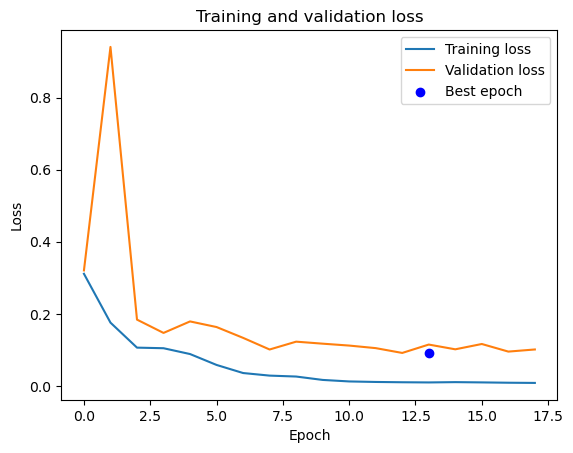

In [83]:
plot_loss(history)

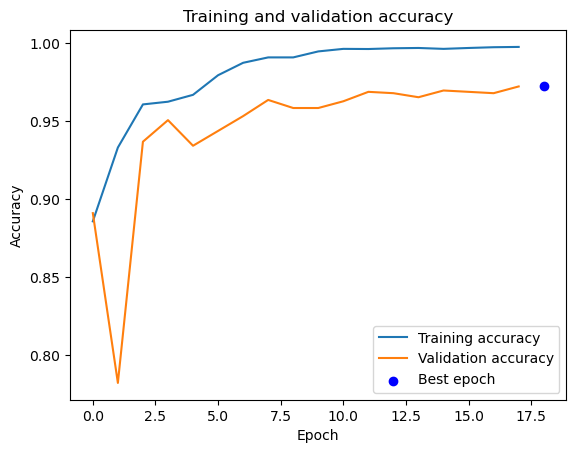

In [84]:
plot_accuracy(history)

Evalutation du modèle

In [89]:
loss, acc = model.evaluate(test_set)
print("Test loss: %.5f" % loss)
print("Test accuracy: %.2f%%" % (100.0 * acc))
print("Error rate: %.2f%%" % (100.0 * (1-acc)))

46/46 [==============================] - 22s 478ms/step - loss: 0.1208 - accuracy: 0.9699
Test loss: 0.12079
Test accuracy: 96.99%
Error rate: 3.01%


In [101]:
prediction_res_net =  model.predict(test_set)

46/46 [==============================] - 22s 473ms/step


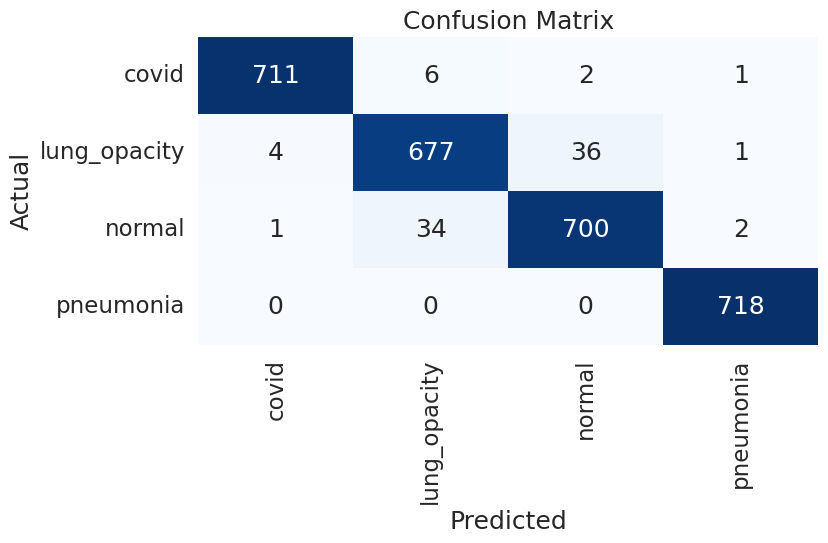

In [133]:
affichage_matrix_confusion(y_true, prediction_res_net, classes)

Erreur par class sur l'échantillon sur le test_set

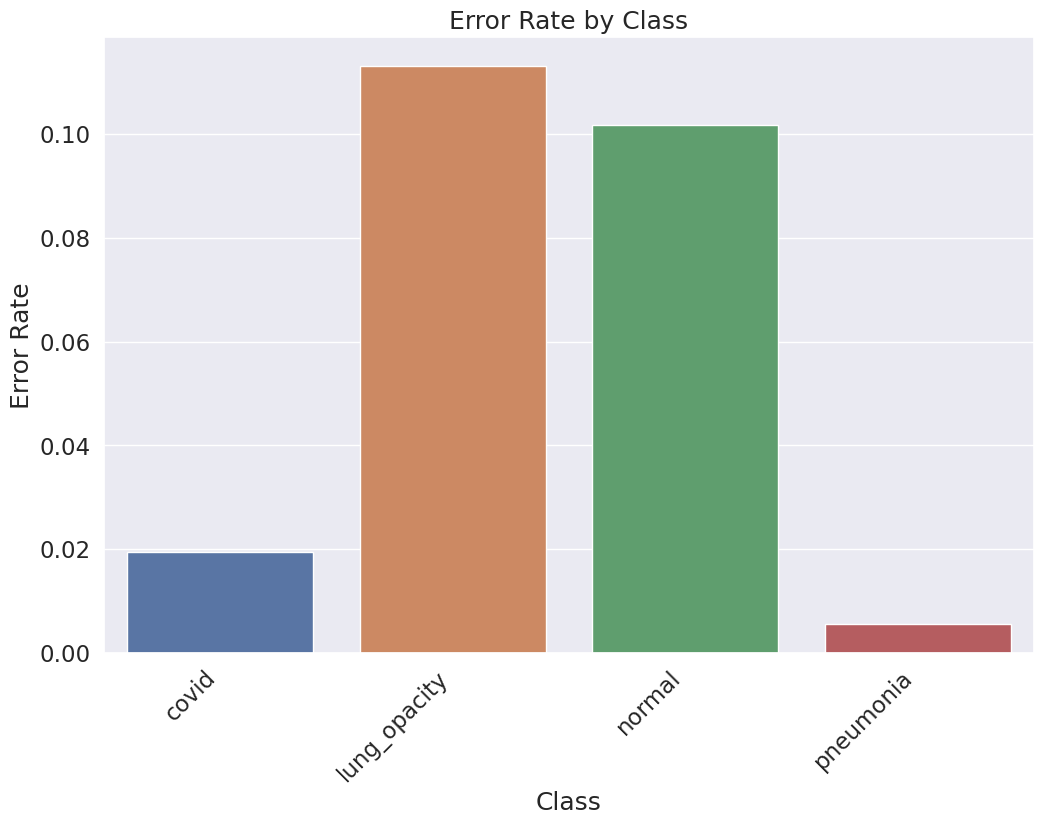

In [145]:
afficher_erreur_class(y_true,prediction_res_net,classes = classes)

## Modèle pré-entrainés : Modèle VGG16

In [27]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [29]:
# Loading VGG16 model
model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(299,299,3))

In [30]:
model_vgg16.trainable = False
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [36]:
model_2 = keras.Sequential(
    [
        keras.Input(shape=(299,299,3)),
        model_vgg16,
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 41472)             0         
                                                                 
 dropout_3 (Dropout)         (None, 41472)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               10617088  
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                      

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

In [39]:
start_time = time.time()
history_vgg16 = model_2.fit(train_set,validation_data=valid_set,batch_size=64,epochs=20, callbacks=[es])
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20
163/163 [==============================] - 348s 2s/step - loss: 0.4718 - accuracy: 0.8133 - val_loss: 0.5810 - val_accuracy: 0.7753
Epoch 2/20
163/163 [==============================] - 283s 2s/step - loss: 0.3215 - accuracy: 0.8764 - val_loss: 0.3376 - val_accuracy: 0.8669
Epoch 3/20
163/163 [==============================] - 284s 2s/step - loss: 0.2846 - accuracy: 0.8915 - val_loss: 0.2945 - val_accuracy: 0.8842
Epoch 4/20
163/163 [==============================] - 285s 2s/step - loss: 0.2562 - accuracy: 0.9057 - val_loss: 0.2796 - val_accuracy: 0.8971
Epoch 5/20
163/163 [==============================] - 284s 2s/step - loss: 0.2458 - accuracy: 0.9085 - val_loss: 0.2358 - val_accuracy: 0.9092
Epoch 6/20
163/163 [==============================] - 286s 2s/step - loss: 0.2230 - accuracy: 0.9145 - val_loss: 0.2450 - val_accuracy: 0.9067
Epoch 7/20
163/163 [==============================] - 284s 2s/step - loss: 0.2244 - accuracy: 0.9171 - val_loss: 0.2508 - val_accuracy: 0.9032

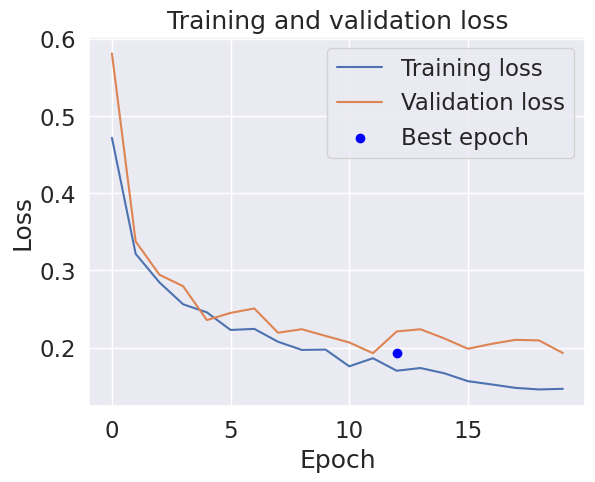

In [72]:
plot_loss(history_vgg16)

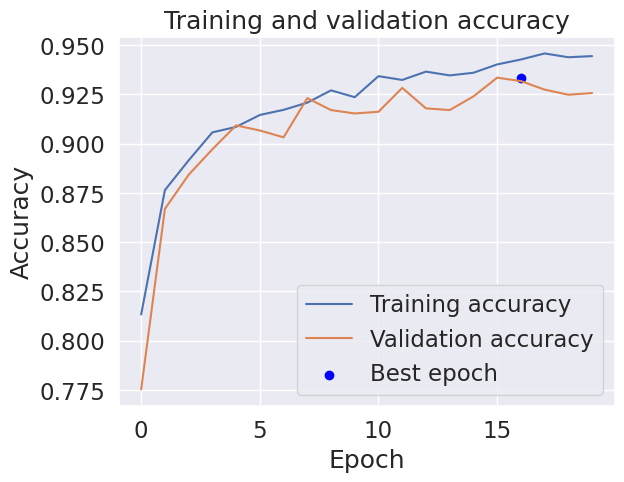

In [73]:
plot_accuracy(history_vgg16)

In [42]:
loss_vgg16, acc_vgg16 = model_2.evaluate(test_set)
print("Test loss: %.5f" % loss_vgg16)
print("Test accuracy: %.2f%%" % (100.0 * acc_vgg16))
print("Error rate: %.2f%%" % (100.0 * (1-acc_vgg16)))

46/46 [==============================] - 32s 702ms/step - loss: 0.1736 - accuracy: 0.9371
Test loss: 0.17359
Test accuracy: 93.71%
Error rate: 6.29%


In [43]:
predict_vgg15 =  model_2.predict(test_set)

46/46 [==============================] - 21s 448ms/step


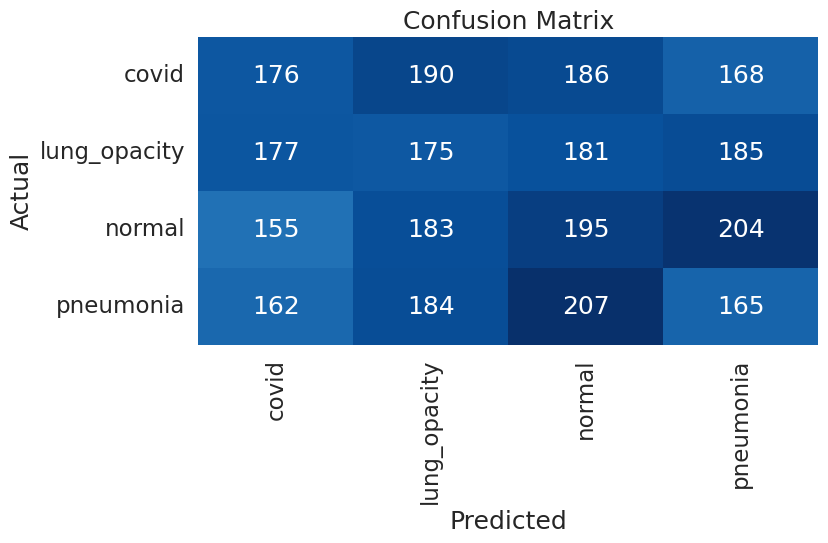

In [47]:
affichage_matrix_confusion(y_true, predict_vgg15, classes)

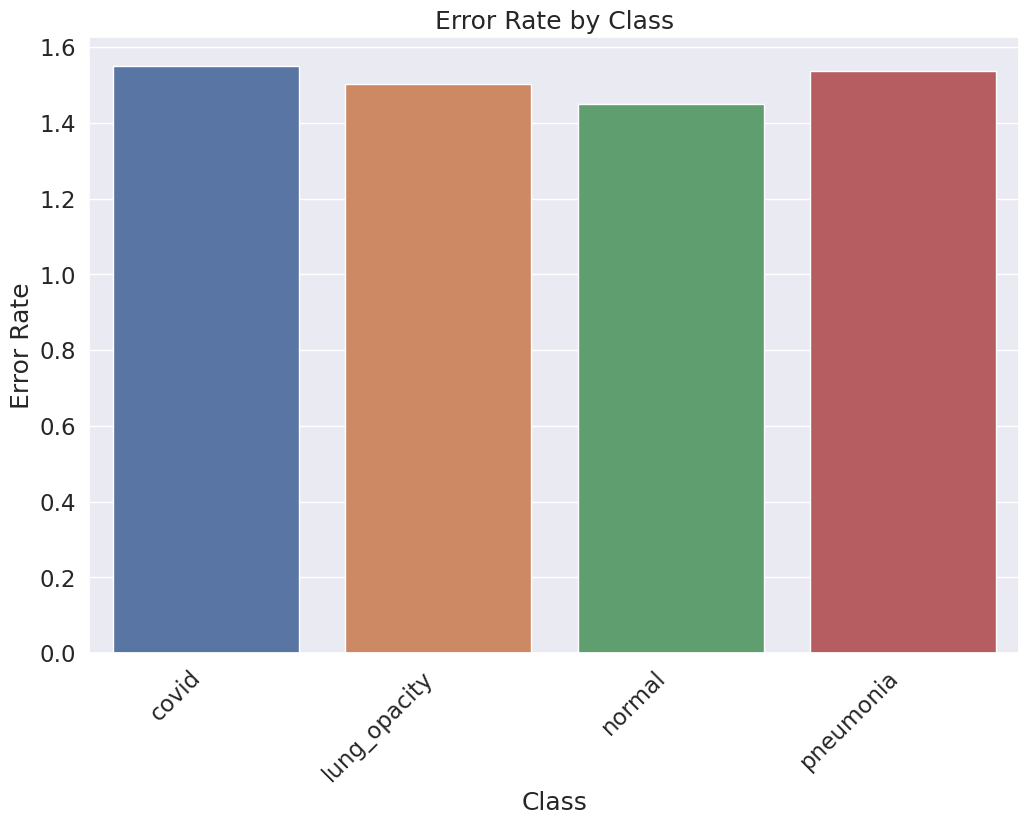

In [48]:
afficher_erreur_class(y_true,predict_vgg15,classes = classes)

## Modèle pré-entrainés : Modèle VGG19

In [33]:
from tensorflow.keras.applications import VGG19

In [34]:
# Création du modèle
model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(299,299,3))
model_vgg19.trainable = False
model_vgg19.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                              

In [57]:
model_3 = keras.Sequential(
    [
        keras.Input(shape=(299,299,3)),
        model_vgg19,
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(256),
        layers.Activation("relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [58]:
model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

In [59]:
start_time = time.time()
history_vgg19 = model_3.fit(train_set,validation_data=valid_set,batch_size=64,epochs=20, callbacks=[es])
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20
163/163 [==============================] - 288s 2s/step - loss: 1.3392 - accuracy: 0.7201 - val_loss: 0.4910 - val_accuracy: 0.8176
Epoch 2/20
163/163 [==============================] - 281s 2s/step - loss: 0.4253 - accuracy: 0.8373 - val_loss: 0.4836 - val_accuracy: 0.8107
Epoch 3/20
163/163 [==============================] - 281s 2s/step - loss: 0.3934 - accuracy: 0.8452 - val_loss: 0.4455 - val_accuracy: 0.8245
Epoch 4/20
163/163 [==============================] - 283s 2s/step - loss: 0.3502 - accuracy: 0.8615 - val_loss: 0.3200 - val_accuracy: 0.8799
Epoch 5/20
163/163 [==============================] - 281s 2s/step - loss: 0.3348 - accuracy: 0.8721 - val_loss: 0.3746 - val_accuracy: 0.8583
Epoch 6/20
163/163 [==============================] - 283s 2s/step - loss: 0.3225 - accuracy: 0.8756 - val_loss: 0.3044 - val_accuracy: 0.8850
Epoch 7/20
163/163 [==============================] - 281s 2s/step - loss: 0.3112 - accuracy: 0.8793 - val_loss: 0.2836 - val_accuracy: 0.8894

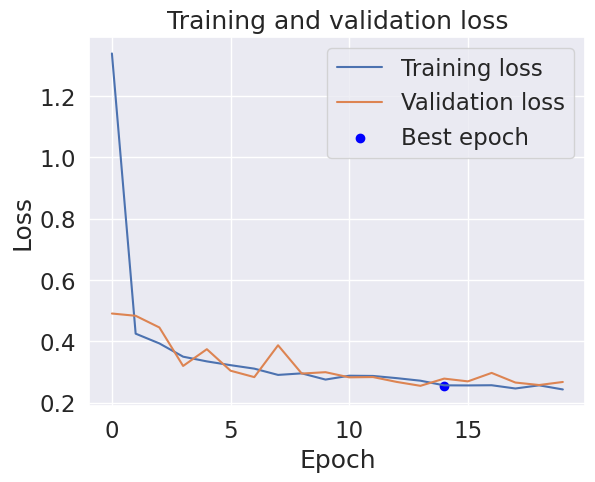

In [61]:
plot_loss(history_vgg19)

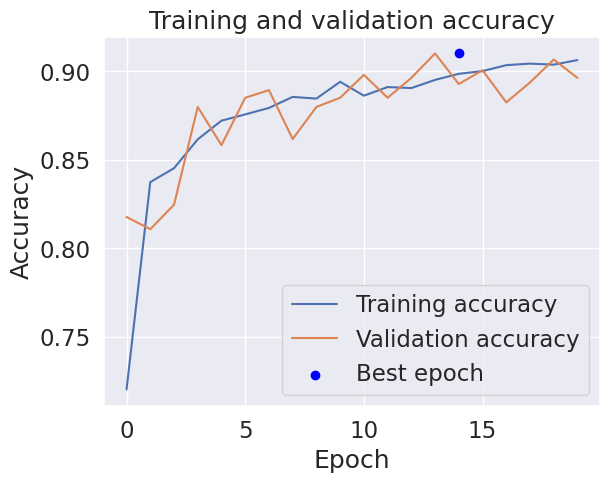

In [67]:
plot_accuracy(history_vgg19)

Evaluation du modèle

In [68]:
loss_vgg19, acc_vgg19 = model_3.evaluate(test_set)
print("Test loss: %.5f" % loss_vgg19)
print("Test accuracy: %.2f%%" % (100.0 * acc_vgg19))
print("Error rate: %.2f%%" % (100.0 * (1-acc_vgg19)))

46/46 [==============================] - 23s 490ms/step - loss: 0.2450 - accuracy: 0.9101
Test loss: 0.24498
Test accuracy: 91.01%
Error rate: 8.99%


In [69]:
predict_vgg19 = model_3.predict(test_set)

46/46 [==============================] - 21s 462ms/step


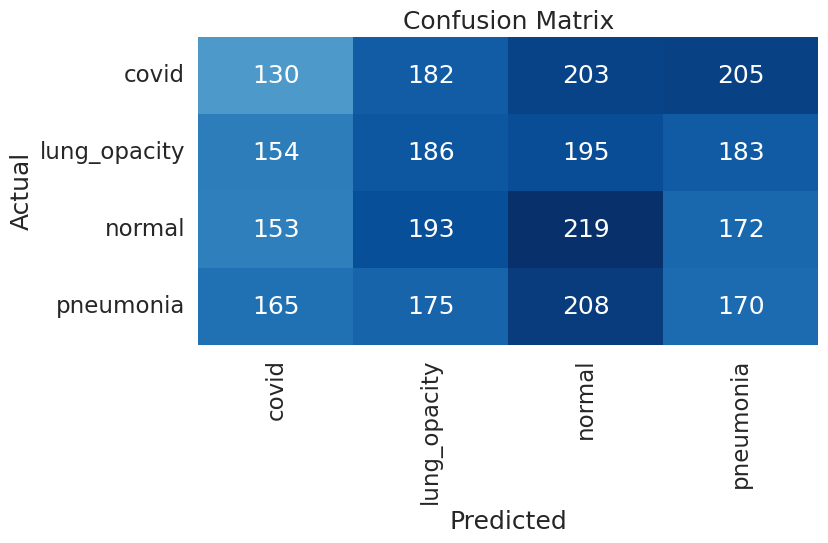

In [70]:
affichage_matrix_confusion(y_true, predict_vgg19, classes)

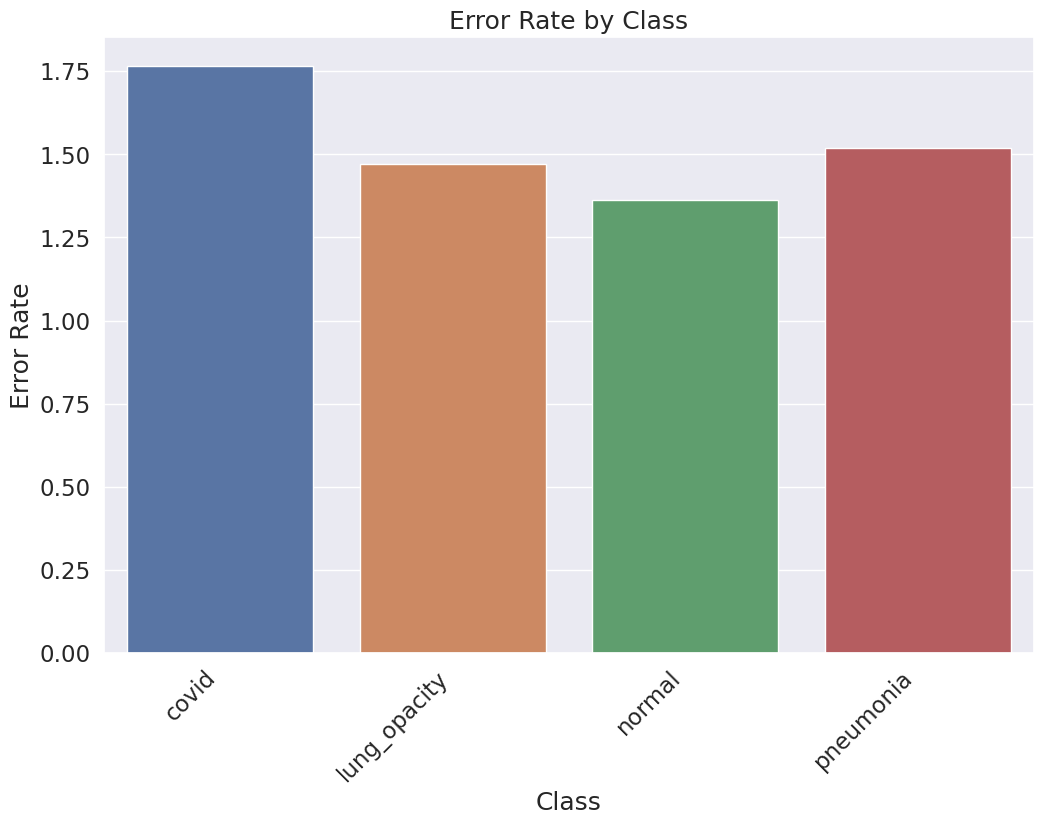

In [71]:
afficher_erreur_class(y_true,predict_vgg19,classes = classes)

# Modèle CNN

In [81]:
model_cnn = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 341056)            0         
                                                                 
 dropout_7 (Dropout)         (None, 341056)           

In [82]:
model_cnn.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [83]:
start_time = time.time()
history_cnn = model_cnn.fit(train_set,validation_data=valid_set,batch_size=64,epochs=20)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20
163/163 [==============================] - 285s 2s/step - loss: 1.1945 - accuracy: 0.5928 - val_loss: 0.8404 - val_accuracy: 0.6379
Epoch 2/20
163/163 [==============================] - 272s 2s/step - loss: 0.7345 - accuracy: 0.6972 - val_loss: 0.6798 - val_accuracy: 0.7226
Epoch 3/20
163/163 [==============================] - 286s 2s/step - loss: 0.6434 - accuracy: 0.7366 - val_loss: 1.0596 - val_accuracy: 0.6067
Epoch 4/20
163/163 [==============================] - 274s 2s/step - loss: 0.6014 - accuracy: 0.7590 - val_loss: 0.6160 - val_accuracy: 0.7381
Epoch 5/20
163/163 [==============================] - 269s 2s/step - loss: 0.5833 - accuracy: 0.7720 - val_loss: 0.5585 - val_accuracy: 0.7874
Epoch 6/20
163/163 [==============================] - 268s 2s/step - loss: 0.5496 - accuracy: 0.7850 - val_loss: 0.4975 - val_accuracy: 0.7943
Epoch 7/20
163/163 [==============================] - 268s 2s/step - loss: 0.5924 - accuracy: 0.7992 - val_loss: 0.6516 - val_accuracy: 0.7684

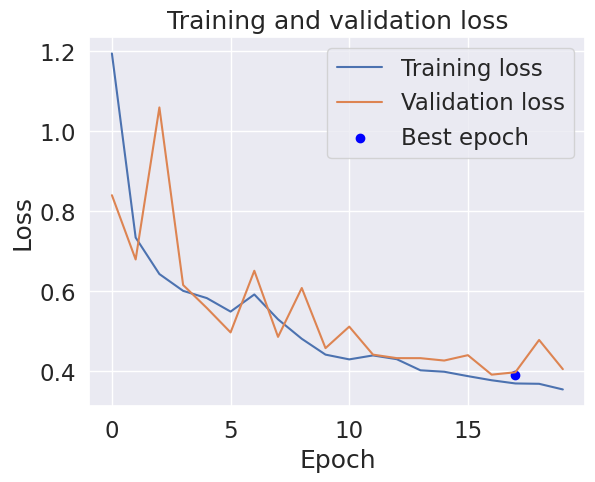

In [84]:
plot_loss(history_cnn)

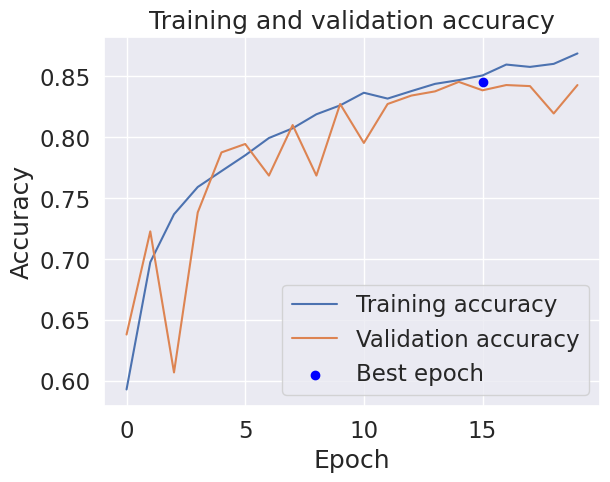

In [85]:
plot_accuracy(history_cnn)

In [88]:
loss_cnn, acc_cnn = model_cnn.evaluate(test_set)
print("Test loss: %.5f" % loss_cnn)
print("Test accuracy: %.2f%%" % (100.0 * acc_cnn))
print("Error rate: %.2f%%" % (100.0 * (1-acc_cnn)))

46/46 [==============================] - 22s 470ms/step - loss: 0.3579 - accuracy: 0.8731
Test loss: 0.35786
Test accuracy: 87.31%
Error rate: 12.69%


In [89]:
predict_cnn = model_cnn.predict(test_set)

46/46 [==============================] - 19s 410ms/step


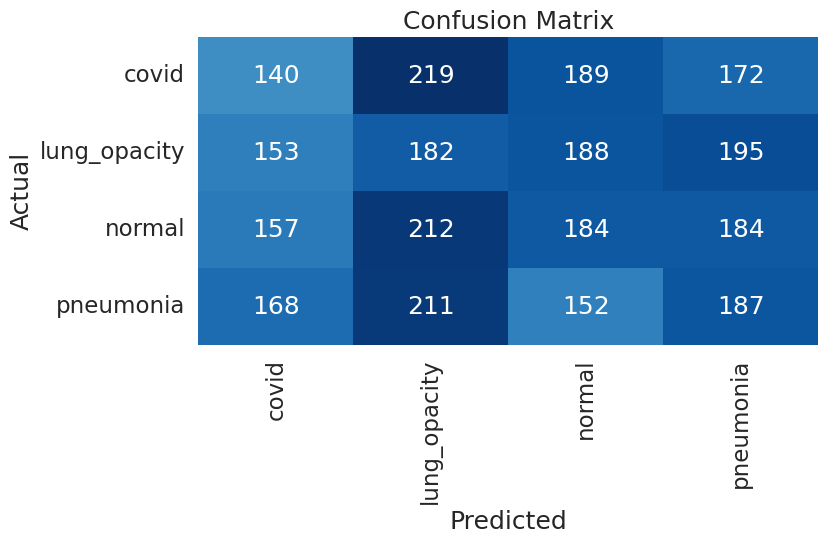

In [90]:
affichage_matrix_confusion(y_true, predict_cnn, classes)

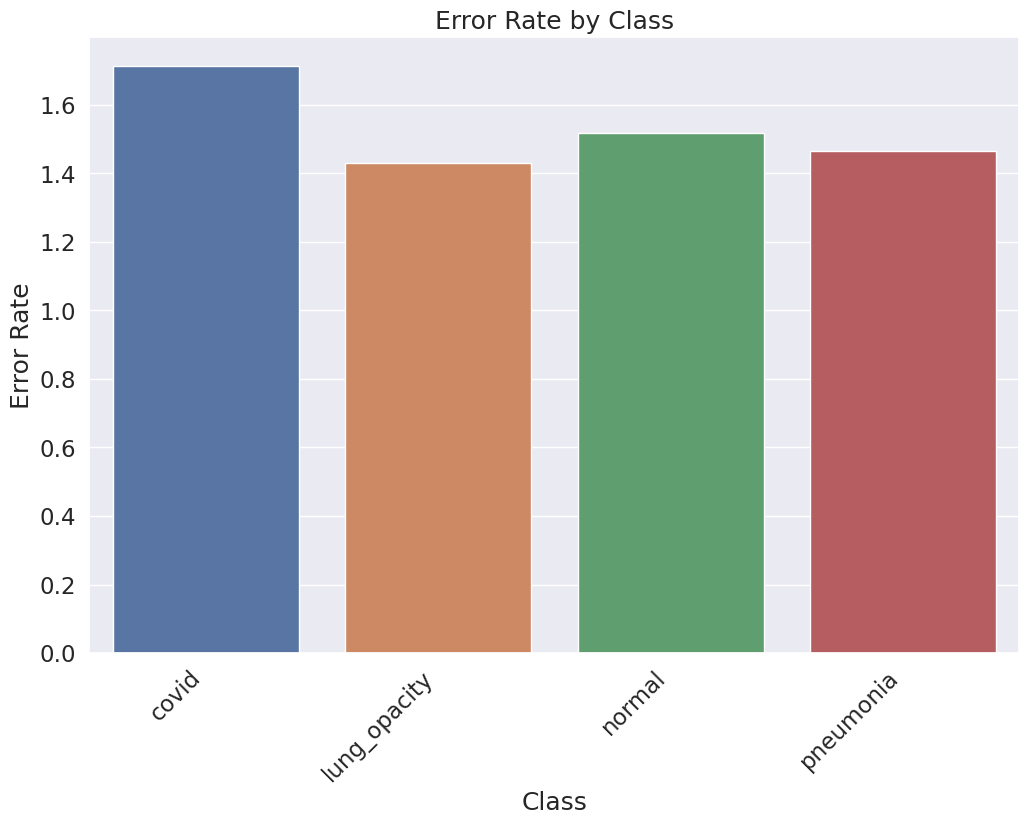

In [91]:
afficher_erreur_class(y_true,predict_cnn,classes = classes)

In [92]:
model_cnn.save("modelCNN")

## Modèle pré-entrainé :  Modèle Xception

In [26]:
from keras.applications.xception import Xception

In [37]:
model_xception = Xception(weights = None, input_shape = (299,299,3), classes = num_classes)
model_xception.trainable = False
#model_xception.summary()

In [39]:
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
start_time = time.time()
history_xception = model_xception.fit(train_set,validation_data=valid_set,batch_size=64,epochs=20)
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20
163/163 [==============================] - 362s 2s/step - loss: 1.3863 - accuracy: 0.2598 - val_loss: 1.3863 - val_accuracy: 0.2532
Epoch 2/20
163/163 [==============================] - 274s 2s/step - loss: 1.3863 - accuracy: 0.2648 - val_loss: 1.3863 - val_accuracy: 0.2463
Epoch 3/20
163/163 [==============================] - 272s 2s/step - loss: 1.3863 - accuracy: 0.2628 - val_loss: 1.3863 - val_accuracy: 0.2498
Epoch 4/20
163/163 [==============================] - 272s 2s/step - loss: 1.3863 - accuracy: 0.2598 - val_loss: 1.3863 - val_accuracy: 0.2394
Epoch 5/20
163/163 [==============================] - 273s 2s/step - loss: 1.3863 - accuracy: 0.2601 - val_loss: 1.3863 - val_accuracy: 0.2550
Epoch 6/20
163/163 [==============================] - 273s 2s/step - loss: 1.3863 - accuracy: 0.2571 - val_loss: 1.3863 - val_accuracy: 0.2463
Epoch 7/20
163/163 [==============================] - 272s 2s/step - loss: 1.3863 - accuracy: 0.2590 - val_loss: 1.3863 - val_accuracy: 0.2506

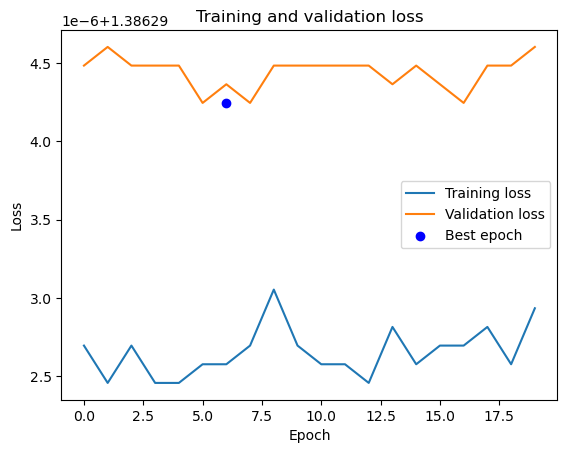

In [47]:
plot_loss(history_xception)

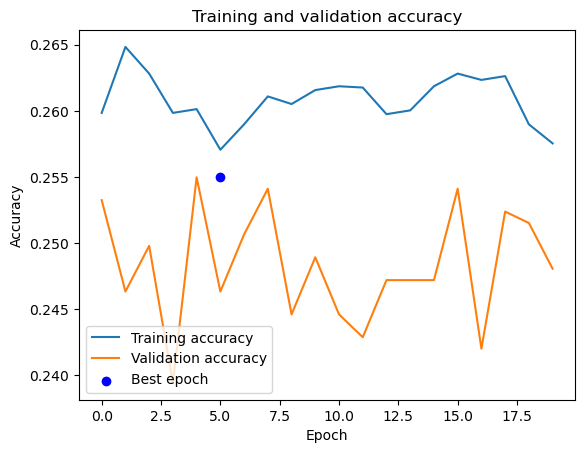

In [48]:
plot_accuracy(history_xception)

In [51]:
loss_xception, acc_xception = model_xception.evaluate(test_set)
print("Test loss: %.5f" % loss_xception)
print("Test accuracy: %.2f%%" % (100.0 * acc_xception))
print("Error rate: %.2f%%" % (100.0 * (1-acc_xception)))

46/46 [==============================] - 21s 448ms/step - loss: 1.3863 - accuracy: 0.2586
Test loss: 1.38629
Test accuracy: 25.86%
Error rate: 74.14%


In [49]:
predict_xception = model_xception.predict(test_set)

46/46 [==============================] - 22s 456ms/step


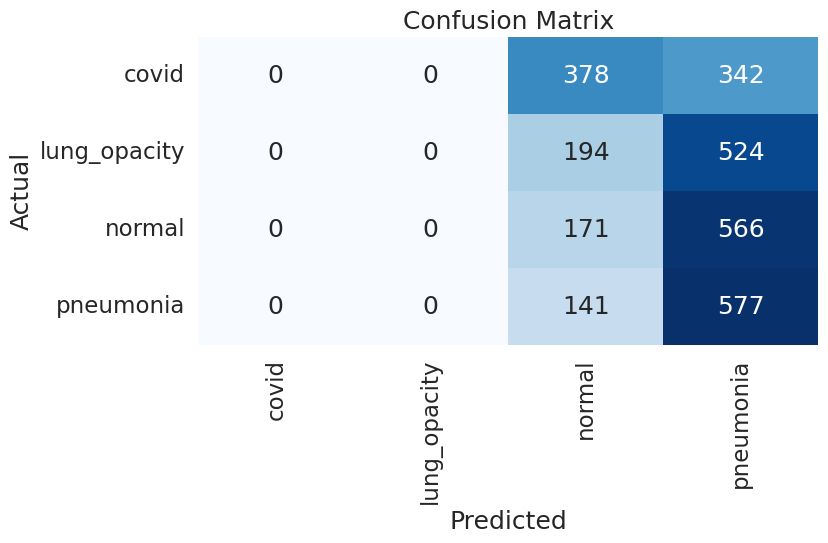

In [50]:
affichage_matrix_confusion(y_true, predict_xception, classes)

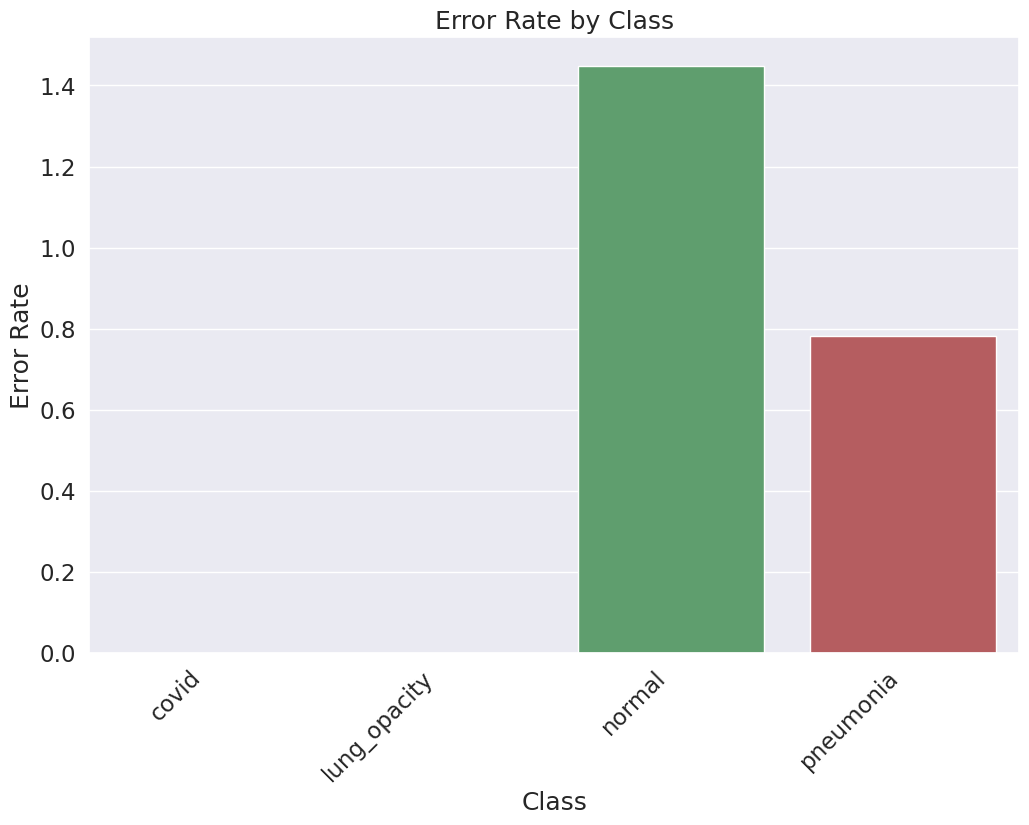

In [52]:
afficher_erreur_class(y_true,predict_xception,classes = classes)

## Modèle à couches 4 de convolutions et normalisation Batch : PaquarseCouche4

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
# exemple cours
# https://keras.io/api/layers/
#from tensorflow.keras.layers import Dense, BatchNormalization
model_paquarse4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model_paquarse4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 299, 299, 32)     128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 299, 299, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 297, 297, 32)      9248      
                                                                 
 batch_normalization_11 (Bat  (None, 297, 297, 32)     128       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 297, 297, 32)     

In [40]:
model_paquarse4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

In [41]:
start_time = time.time()
history_paquarse4 = model_paquarse4.fit(train_set,validation_data=valid_set,batch_size=64,epochs=20, callbacks=[es])
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20


2023-04-04 11:45:06.839091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 316s 2s/step - loss: 0.7453 - accuracy: 0.7189 - val_loss: 2.2702 - val_accuracy: 0.3708
Epoch 2/20
163/163 [==============================] - 270s 2s/step - loss: 0.4912 - accuracy: 0.7967 - val_loss: 2.5771 - val_accuracy: 0.3812
Epoch 3/20
163/163 [==============================] - 269s 2s/step - loss: 0.4226 - accuracy: 0.8344 - val_loss: 1.0320 - val_accuracy: 0.6007
Epoch 4/20
163/163 [==============================] - 270s 2s/step - loss: 0.3797 - accuracy: 0.8493 - val_loss: 0.4429 - val_accuracy: 0.8263
Epoch 5/20
163/163 [==============================] - 269s 2s/step - loss: 0.3628 - accuracy: 0.8589 - val_loss: 2.9461 - val_accuracy: 0.5506
Epoch 6/20
163/163 [==============================] - 269s 2s/step - loss: 0.3326 - accuracy: 0.8715 - val_loss: 0.4392 - val_accuracy: 0.8090
Epoch 7/20
163/163 [==============================] - 269s 2s/step - loss: 0.3170 - accuracy: 0.8765 - val_loss: 0.7618 - val_accuracy: 0.6880
Epoch 8/20

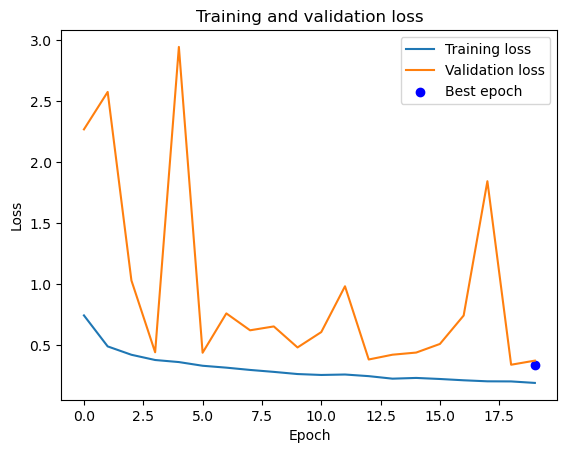

In [42]:
plot_loss(history_paquarse4)

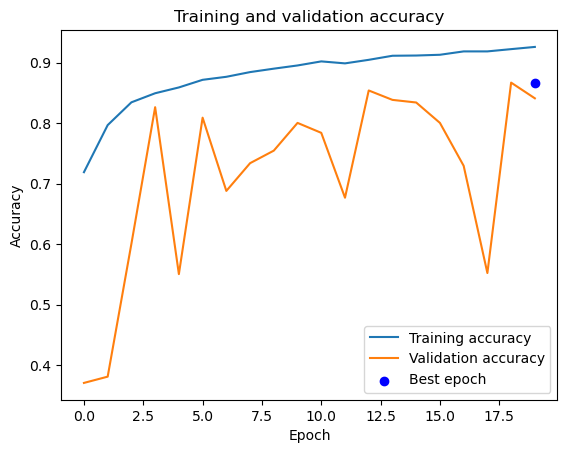

In [43]:
plot_accuracy(history_paquarse4)

In [44]:
loss_paquarse4, acc_paquarse4 = model_paquarse4.evaluate(test_set)
print("Test loss: %.5f" % loss_paquarse4)
print("Test accuracy: %.2f%%" % (100.0 * acc_paquarse4))
print("Error rate: %.2f%%" % (100.0 * (1-acc_paquarse4)))

46/46 [==============================] - 21s 467ms/step - loss: 0.3673 - accuracy: 0.8483
Test loss: 0.36734
Test accuracy: 84.83%
Error rate: 15.17%


In [45]:
predict_paquarse4 = model_paquarse4.predict(test_set)

46/46 [==============================] - 18s 395ms/step


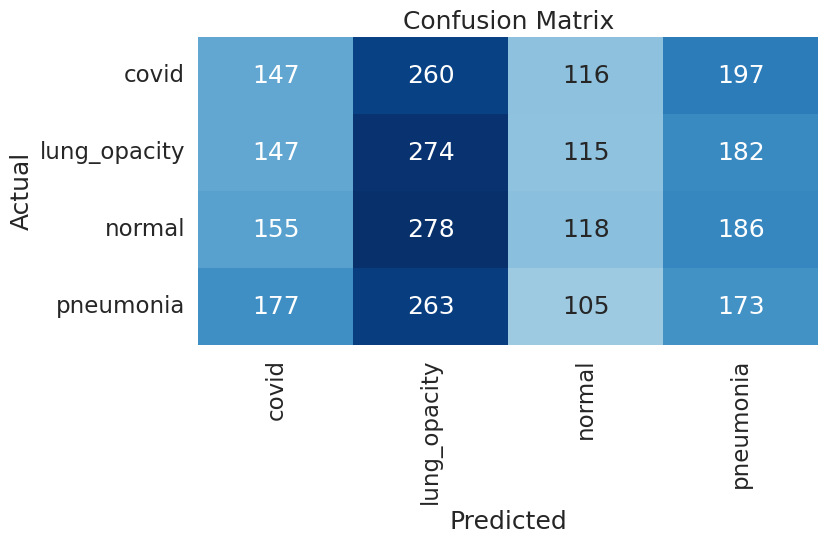

In [46]:
affichage_matrix_confusion(y_true, predict_paquarse4, classes)

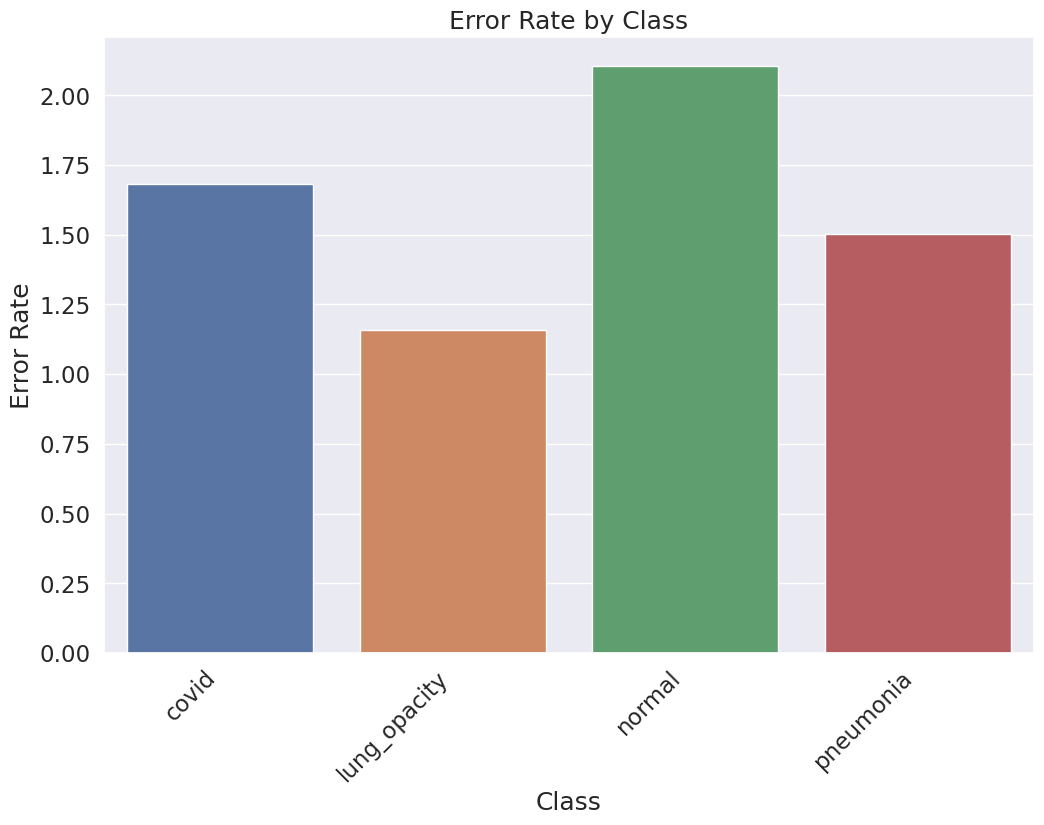

In [47]:
afficher_erreur_class(y_true,predict_paquarse4,classes = classes)

## Modèle à 6 couches de convolutions et normalisation

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
model6couches = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Conv2D(32, kernel_size=(3,3), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Conv2D(32, kernel_size=(3,3), padding="valid"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2, seed=235),
        layers.Flatten(),
        layers.Dropout(0.5, seed=235),
        layers.Dense(32),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.5, seed=235),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model6couches.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 299, 299, 32)      896       
                                                                 
 batch_normalization_18 (Bat  (None, 299, 299, 32)     128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 299, 299, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 297, 297, 32)      9248      
                                                                 
 batch_normalization_19 (Bat  (None, 297, 297, 32)     128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 297, 297, 32)     

In [40]:
model6couches.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

In [41]:
start_time = time.time()
history_paquarse5 = model6couches.fit(train_set,validation_data=valid_set,batch_size=64,epochs=20, callbacks=[es])
print("Temps de calcul :", time.time() - start_time)

Epoch 1/20


2023-04-05 07:43:25.747958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 [==============================] - 353s 2s/step - loss: 0.8952 - accuracy: 0.6072 - val_loss: 1.6524 - val_accuracy: 0.2550
Epoch 2/20
163/163 [==============================] - 288s 2s/step - loss: 0.6849 - accuracy: 0.6982 - val_loss: 1.4111 - val_accuracy: 0.4192
Epoch 3/20
163/163 [==============================] - 284s 2s/step - loss: 0.6136 - accuracy: 0.7349 - val_loss: 0.9649 - val_accuracy: 0.6266
Epoch 4/20
163/163 [==============================] - 283s 2s/step - loss: 0.5812 - accuracy: 0.7533 - val_loss: 0.7531 - val_accuracy: 0.6975
Epoch 5/20
163/163 [==============================] - 285s 2s/step - loss: 0.5423 - accuracy: 0.7703 - val_loss: 0.6061 - val_accuracy: 0.7718
Epoch 6/20
163/163 [==============================] - 291s 2s/step - loss: 0.5367 - accuracy: 0.7773 - val_loss: 0.8530 - val_accuracy: 0.6335
Epoch 7/20
163/163 [==============================] - 284s 2s/step - loss: 0.5142 - accuracy: 0.7875 - val_loss: 0.6079 - val_accuracy: 0.7398
Epoch 8/20

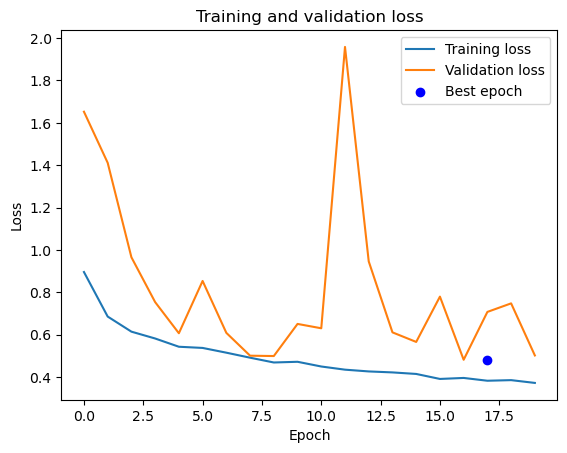

In [43]:
plot_loss(history_paquarse5)

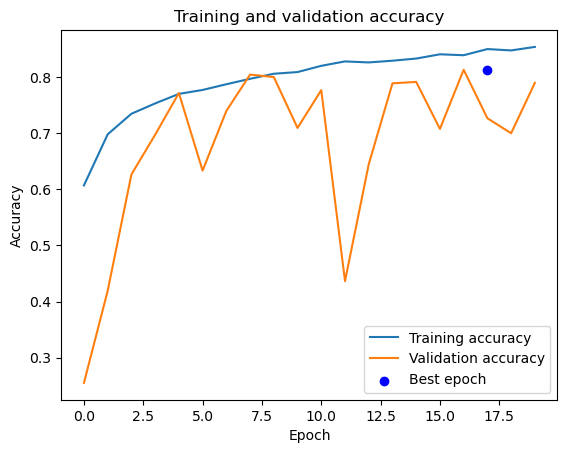

In [44]:
plot_accuracy(history_paquarse5)

In [46]:
loss_paquarse6, acc_paquarse6 = model6couches.evaluate(test_set)
print("Test loss: %.5f" % loss_paquarse6)
print("Test accuracy: %.2f%%" % (100.0 * acc_paquarse6))
print("Error rate: %.2f%%" % (100.0 * (1-acc_paquarse6)))

46/46 [==============================] - 20s 444ms/step - loss: 0.4032 - accuracy: 0.8438
Test loss: 0.40322
Test accuracy: 84.38%
Error rate: 15.62%


In [47]:
predict_paquarse6 = model6couches.predict(test_set)

46/46 [==============================] - 20s 422ms/step


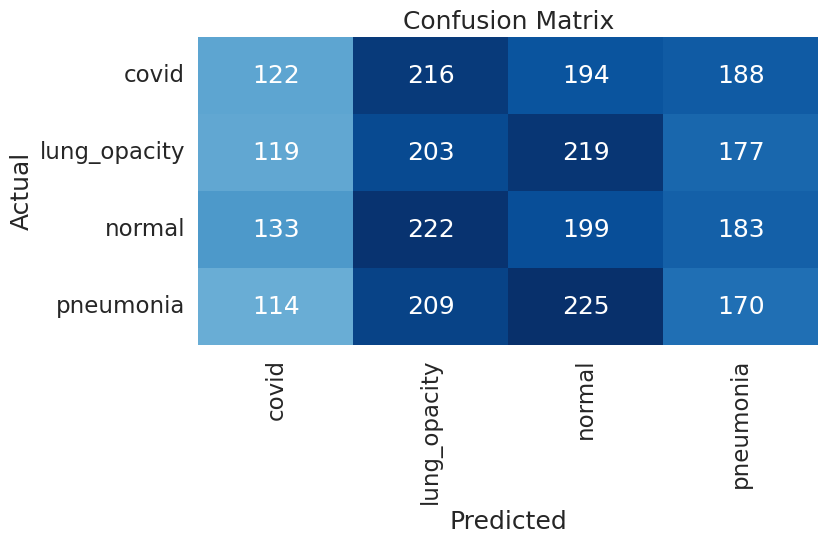

In [48]:
affichage_matrix_confusion(y_true, predict_paquarse6, classes)

In [ ]:
afficher_erreur_class(y_true,predict_paquarse6,classes = classes)